# SWAPnet experiments

In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import random

import cirq
import cirq_google as cg
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

from qbitmap import metrics
from qbitmap import utils
from qbitmap import calibration_data
from qbitmap.noise.simple_noise_model import SimpleNoiseModel
from qbitmap import circuits
from qbitmap import diagnostics

### DFE on a single qubit state

This is straightforward if you have access to $U$. We prepare a state of the form

$$
|\psi\rangle\langle\psi| = \frac{1}{2}\left(I + \cos\theta X + \sin \theta Y\right)
$$

where $|\psi\rangle = U(\theta) |0\rangle \langle 0|U^\dagger$. Then the fidelity estimtaor is given by 
$$
\text{Tr}\left( U |0\rangle \langle 0| U^\dagger \rho \right)
$$
where $\rho$ is the experimentally prepared state. This is intuitively obvious; to measure the fidelity of $U|0\rangle$ we apply $U^\dagger$ and check $p(0)$.

TIMESTAMP: 1629190714052



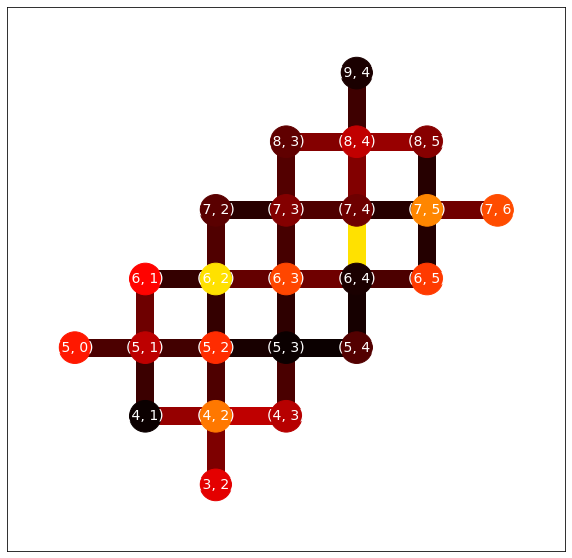

In [127]:
from qbitmap import hw

# Don't overwrite any of the analysis using a different processor...!
assert hw.PROCESSOR_ID == "rainbow"


target_calibration = hw.PROCESSOR.get_current_calibration()
TIMESTAMP = target_calibration.timestamp 
# TIMESTAMP = 1629190714052
# target_calibration = hw.PROCESSOR.get_calibration(TIMESTAMP)

print("TIMESTAMP:", TIMESTAMP)

# Target specifically these metrics
metric_1q = "single_qubit_rb_average_error_per_gate"
metric_2q = "two_qubit_sqrt_iswap_gate_xeb_average_error_per_cycle"
calibration = calibration_data.CalibrationWrapper(
    calibration_dct=target_calibration, 
    qubits=hw.DEVICE.qubits, 
    metric_1q=metric_1q, 
    metric_2q=metric_2q
)
fig, ax = plt.subplots(figsize=(10, 10))

calibration.plot_noise_graph(ax=ax)
print()

## Hardware submissions


In [152]:
def state_prep_circuit(qubit, theta):
    """Prepare a known single-qubit state.
    
    This state has the Pauli decomposition
    
        rho = 0.5 * (I + cos(theta) X + sin(theta) Y)
    
    """
    sub = cirq.Circuit()
    # Sorry, opposite naming conventions from spherical coords
    phi = 2*np.pi/3
    sub += cirq.ry(phi).on(qubit)
    sub += cirq.rz(theta).on(qubit)
    sub = cg.optimized_for_sycamore(sub, optimizer_type='sqrt_iswap')
    
    return sub
def make_full_circuit(qubits, theta, measure):
    sub = state_prep_circuit(qubits[0], theta)
    return sub + circuits.iswap_network_line_topology(template_qubits, measure=measure, native=True)   

def make_dfe_circuit(qubits, theta, measure='m'):
    out = make_full_circuit(template_qubits, theta, measure='m')
    out += cirq.inverse(state_prep_circuit(qubits[-1], theta))
    if measure:
        out += cirq.measure(qubits[-1], key=measure)
    return out


In [154]:
template_qubits = cirq.GridQubit.rect(1, 9)
n_qubits = len(template_qubits)

# state prep circuit
theta = np.pi/4
structured_circuit = make_full_circuit(template_qubits, theta, measure='m')
forward_depth = len(structured_circuit)

DFE_circuit = make_dfe_circuit(template_qubits, theta, measure='m')

structured_circuit_LE = circuits.loschmidt_circuit(make_full_circuit, template_qubits, theta, measure="m")

print("FORWARDS CIRCUIT")
display(structured_circuit)
print("FORWARDS DEPTH=", forward_depth)
print("DFE CIRCUIT")
display(DFE_circuit)
print("LOSCHMIDT CIRCUIT")
display(structured_circuit_LE)

FORWARDS CIRCUIT


(0, 0): ───PhXZ(a=0.5,x=0.667,z=0.25)───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        │           │
(0, 1): ────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                │           │
(0, 2): ────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                        │           │
(0, 3): ────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                │           │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────
                                                                                                                                        │           │
(0, 5): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────
                                                                                                                                                                │           │
(0, 6): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────
                                                                                                                                                                                        │           │
(0, 7): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────
                                                                                                                                                                                                                │           │
(0, 8): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───

FORWARDS DEPTH= 17
DFE CIRCUIT


(0, 0): ───PhXZ(a=0.5,x=0.667,z=0.25)───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        │           │
(0, 1): ────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                │           │
(0, 2): ────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                        │           │
(0, 3): ────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                │           │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                        │           │
(0, 5): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                │           │
(0, 6): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                        │           │
(0, 7): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap────────────────────────────────────────────────
                                                                                                                                                                                                                │           │
(0, 8): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───PhXZ(a=0.75,x=-0.667,z=-0.25)───M('m')───

LOSCHMIDT CIRCUIT


(0, 0): ───PhXZ(a=0.5,x=0.667,z=0.25)───iSwap───────iSwap─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────iSwap────────PhXZ(a=0.75,x=-0.667,z=-0.25)───M────────
                                        │           │                                                                                                                                                                                                                                                                                                                                                                         │            │                                            │
(0, 1): ────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────iSwap────────iSwap^-0.5───iSwap^-0.5───────────────────────────────────M────────
                                                                │           │                                                                                                                                                                                                                                                                                                                       │            │                                                                      │
(0, 2): ────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────iSwap────────iSwap^-0.5───iSwap^-0.5─────────────────────────────────────────────────────────────M────────
                                                                                        │           │                                                                                                                                                                                                                                                                     │            │                                                                                                │
(0, 3): ────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────iSwap────────iSwap^-0.5───iSwap^-0.5───────────────────────────────────────────────────────────────────────────────────────M────────
                                                                                                                │           │                                                                                                                                                                                                                   │            │                                                                                                                          │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^0.5───iSwap^0.5───iSwap───────iSwap───────────────────────

In [155]:
random_circuit_LE_half = circuits.loschmidt_circuit(
    circuits.create_random_line_circuit, 
    template_qubits, 
    depth=forward_depth // 2, 
    seed=123, 
    measure="m")
print("RANDOM CIRCUIT, depth={} (forward depth)".format(len(random_circuit_LE_half)))
display(random_circuit_LE_half)


RANDOM CIRCUIT, depth=17 (forward depth)


(0, 0): ───PhX(0.5)^0.5──────────────────────PhX(-0.5)^0.5────FSim(0.25π, 0)───PhX(-0.75)^0.5────────────────────PhX(1)^0.5───────FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(1)^-0.5─────────────────────────PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(-0.5)^-0.5──────────────────────PhX(0.5)^-0.5─────M────────
                                                              │                                                                   │                │                                                                       │                                                                       │
(0, 1): ───PhX(0.25)^0.5────FSim(0.25π, 0)───PhX(-0.25)^0.5───FSim(0.25π, 0)───PhX(1)^0.5───────FSim(0.25π, 0)───PhX(0)^0.5───────FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(0)^-0.5───────FSim(-0.25π, 0)───PhX(1)^-0.5───────FSim(-0.25π, 0)───PhX(-0.25)^-0.5───FSim(-0.25π, 0)───PhX(0.25)^-0.5────M────────
                            │                                                                   │                                                                                      │                                                                       │                                   │
(0, 2): ───PhX(0.5)^0.5─────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(0.5)^0.5─────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(0.5)^-0.5─────FSim(-0.25π, 0)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(0.5)^-0.5─────M────────
                                                              │                                                                   │                │                                                                       │                                                                       │
(0, 3): ───PhX(-0.5)^0.5────FSim(0.25π, 0)───PhX(0.5)^0.5─────FSim(0.25π, 0)───PhX(1)^0.5───────FSim(0.25π, 0)───PhX(0.75)^0.5────FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(0.75)^-0.5────FSim(-0.25π, 0)───PhX(1)^-0.5───────FSim(-0.25π, 0)───PhX(0.5)^-0.5─────FSim(-0.25π, 0)───PhX(-0.5)^-0.5────M────────
                            │                                                                   │                                                                                      │                                                                       │                                   │
(0, 4): ───PhX(0)^0.5───────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(0.75)^0.5────FSim(0.25π, 0)───PhX(-0.25)^0.5───FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(-0.25)^-0.5───FSim(-0.25π, 0)───PhX(0.75)^-0.5────FSim(-0.25π, 0)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(0)^-0.5───────M────────
                                                              │                                                                   │                │                                                                       │                                                                       │
(0, 5): ───PhX(-0.5)^0.5────FSim(0.25π, 0)───PhX(1)^0.5───────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(-0.5)^0.5────FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(-0.5)^-0.5────FSim(-0.25π, 0)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(1)^-0.5───────FSim(-0.25π, 0)───PhX(-0.5)^-0.5────M('m')───
                            │                                                                   │                                                                                      │                                                                       │                                   │
(0, 6): ───PhX(0.5)^0.5─────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(-0.25)^0.5───FSim(0.25π, 0)───PhX(0)^0.5───────FSim(0.25π, 0)───FSim(-0.25π, 0)───PhX(0)^-0.5───────FSim(-0.25π, 0)───PhX(-0.25)^-0.5───FSim(-0.25π, 0)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(0.5)^-0.5─────M────────
                                                              │                                                                   │    

In [131]:
noise_graph = calibration.noise_graph
# Pre-compute all of the paths
all_paths = []
for source in noise_graph.nodes():
    for target in noise_graph.nodes():
        if source == target:
            continue            
        all_paths_ij = list(nx.all_simple_paths(noise_graph, source, target, cutoff=n_qubits))
        for v in all_paths_ij:
            if len(v) == n_qubits:
                all_paths.append(v)

print("Found {} paths with {} qubits to attempt".format(len(all_paths), n_qubits))

# Shuffle paths
shuffled_paths = [x for x in all_paths]
np.random.seed(492773)
random.shuffle(shuffled_paths)

Found 4972 paths with 9 qubits to attempt


# EXPERIMENTS COMPLETED. DO NOT RUN

In [164]:
# Dry run tests: 2 passes finished in 1:30 minutes
# = ~45 s per full experiment


# Set DRY_RUN to dump readout ec metadata into a different folder
DRY_RUN = False
def dry_run_print(s, dry_run=DRY_RUN):
    if dry_run:
        print(s)
DATESTR = "20210818"

bf_timestamp = str(TIMESTAMP)
readout_ec_path = "./readout_ec"
if DRY_RUN:
    readout_ec_path = "./dryrun"
    bf_timestamp = str(TIMESTAMP) + str(np.random.random() * 1000)
    
DIAGNOSTIC_REPS = 10_000
REPETITIONS = 15_000
N_EXPERIMENTS = 250

# results[:,0] stores F_LE, results[:,1] stores F, results[:,2] stores F0
# Raw refers to no readout error correction, corr refers to yes readout EC
results_raw = np.zeros((N_EXPERIMENTS, 3))
results_corr = np.zeros((N_EXPERIMENTS, 3))

# Configuration for random circuits
N_TRIALS = 5 # Number of random circuits to attempt per qubit configuration
# For each random circuit, we'll attempt one with(forward depth) and one for 2*(forward depth)
random_results_raw = np.zeros((N_EXPERIMENTS, N_TRIALS))
random_results_corr = np.zeros((N_EXPERIMENTS, N_TRIALS))
seeds = [3882, 175, 802, 993, 22]
assert len(seeds) >= N_TRIALS

used_paths = []

i_RESTART = 0
for i in range(N_EXPERIMENTS):
    if i < i_RESTART:
        continue
    if (i % 5) == 0:
        print(f"run={i}")
        
    # Construct the circuit on this path
    v = shuffled_paths[i]
    targets = [cirq.GridQubit(*x) for x in v]
    qubit_map = dict(zip(template_qubits, targets))   
    used_paths.append(v)
    
    # Perform separable readout error diagnostic
    # Every iteration needs a unique identifier for its readout error diagnostic
    hw_diagnostic_sep = diagnostics.SeparableReadoutErrorDiagnostic(
        timestamp=bf_timestamp + f"_{i}" ,
        qubits=targets,
        repetitions=DIAGNOSTIC_REPS,
        debug=False,
        path=readout_ec_path
    )
    qvals = hw_diagnostic_sep.run(ntrials=1)
    dry_run_print("...readout error diagnostic complete")

#     Compute structured circuit loschmidt survival
#     Don't overwrite the structured LE circuit
    mapped_LE_circuit = structured_circuit_LE.transform_qubits(qubit_map)
    job = hw.ENGINE.run_sweep(
        program=mapped_LE_circuit,
        repetitions=REPETITIONS,
        processor_ids=[hw.PROCESSOR_ID],
        gate_set=hw.GATESET
    )
    # F_LE computation
    LE_counter = job.results()[0].histogram(key="m")
    results_raw[i,0] = LE_counter.get(0) / REPETITIONS
    LE_arr = utils.hist_as_np(LE_counter, n_qubits, REPETITIONS)
    results_corr[i,0] = hw_diagnostic_sep.invert_and_correct(LE_arr)[0]
    dry_run_print("...F_LE complete")

    # Perform Direct Fidelity Estimation with and without readout correction
    mapped_DFE_circuit = DFE_circuit.transform_qubits(qubit_map)
    job = hw.ENGINE.run_sweep(
        program=mapped_DFE_circuit,
        repetitions=REPETITIONS,
        processor_ids=[hw.PROCESSOR_ID],
        gate_set=hw.GATESET   
    )
    # DFE computation; do a lot by hand because this workflow
    # isn't worth cementing into a pipeline
    DFE_counter = job.results()[0].histogram(key="m")
    DFE_hist_raw = np.asarray([DFE_counter.get(0), DFE_counter.get(1)])
    exp_Z_raw = (DFE_hist_raw[0] - DFE_hist_raw[1]) / REPETITIONS
    fid_raw = 0.5 * (1 + exp_Z_raw)
    results_raw[i,1] = fid_raw

    # Readout error correction on just the last qubit
    qmeans = hw_diagnostic_sep.qvals.mean(axis=2)
    q01 = qmeans[0, -1]
    q10 = qmeans[1, -1]
    Q = np.asarray([
        [1 - q10, q01],
        [q10, 1 - q01]
    ])
    DFE_hist_corr = Q @ DFE_hist_raw
    exp_Z_corr = (DFE_hist_corr[0] - DFE_hist_corr[1]) / REPETITIONS
    fid_corr = 0.5 * (1 + exp_Z_corr)
    results_corr[i,1] = fid_corr    

    dry_run_print("...F DFE complete")

    # Perform random circuit runs with readout error correction
    rand_fwd_depth = forward_depth // 2 
    # iterate over random circuit depths
    for j in range(N_TRIALS):
        # Iterate over rand
        random_circuit_LE = circuits.loschmidt_circuit(
            circuits.create_random_line_circuit, 
            template_qubits, 
            depth=rand_fwd_depth, 
            seed=seeds[j] + i, # new seed for every random circuit
            measure="m")
        dry_run_print("rand circuit LE depth={}".format(len(random_circuit_LE)))
        random_circuit_LE = random_circuit_LE.transform_qubits(qubit_map)
        # Submit hardware random circuit
        job = hw.ENGINE.run_sweep(
            program=random_circuit_LE,
            repetitions=REPETITIONS,
            processor_ids=[hw.PROCESSOR_ID],
            gate_set=hw.GATESET
        )
        # raw and corr
        random_counter = job.results()[0].histogram(key="m")
        random_results_raw[i, j] = random_counter.get(0) / REPETITIONS
        rand_arr = utils.hist_as_np(random_counter, n_qubits, REPETITIONS)
        random_results_corr[i,j] = hw_diagnostic_sep.invert_and_correct(rand_arr)[0]
    dry_run_print("...Random F_LE complete")

        
    # Perform zeroth order metric with and without readout error correction assumption
    mapped_forward_circuit = structured_circuit.transform_qubits(qubit_map)
    F0 = metrics.compute_calibration_fidelity(mapped_forward_circuit, noise_graph)
    F0_readout_err = metrics.compute_calibration_fidelity(mapped_forward_circuit, noise_graph, readout_error=True)
    results_corr[i,2] = F0
    results_raw[i,2] = F0_readout_err
        
    if DRY_RUN and i == 10:
        break
    # Caching
    np.save(f"./temp/v1_hw_{DATESTR}_swapnet_line_results_corr_{i}.npy", results_corr)
    np.save(f"./temp/v1_hw_{DATESTR}_swapnet_line_results_raw_{i}.npy", results_raw)
    np.save(f"./temp/v1_hw_{DATESTR}_random_line_results_raw_{i}.npy", random_results_raw)
    np.save(f"./temp/v1_hw_{DATESTR}_random_line_results_corr_{i}.npy", random_results_corr)
    np.save(f"./temp/v1_hw_{DATESTR}_swapnet_line_vs_random_paths_{i}.npy", np.asarray(used_paths))

if not DRY_RUN:
    np.save(f"v1_hw_{DATESTR}_swapnet_line_results_corr.npy", results_corr)
    np.save(f"v1_hw_{DATESTR}_swapnet_line_results_raw.npy", results_raw)
    np.save(f"v1_hw_{DATESTR}_random_line_results_raw.npy", random_results_raw)
    np.save(f"v1_hw_{DATESTR}_random_line_results_corr.npy", random_results_corr)
    np.save(f"v1_hw_{DATESTR}_swapnet_line_vs_random_paths.npy", np.asarray(used_paths))


run=0
run=5
run=10
run=15
run=20
run=25
run=30
run=35
run=40
run=45
run=50
run=55
run=60
run=65
run=70
run=75
run=80
run=85
run=90
run=95
run=100
run=105
run=110
run=115
run=120
run=125
run=130
run=135
run=140
run=145
run=150
run=155
run=160
run=165
run=170
run=175
run=180
run=185
run=190
run=195
run=200
run=205
run=210
run=215
run=220
run=225
run=230
run=235
run=240
run=245


### Stitching operations



In [158]:
results_corr[:10,:]

array([[0.46523047, 0.75386396, 0.88039613],
       [0.53387234, 0.73678692, 0.85658956],
       [0.36858128, 0.77692816, 0.87913679],
       [0.26829273, 0.65105918, 0.89203439],
       [0.60512374, 0.85761305, 0.87858968],
       [0.53423097, 0.73538011, 0.88026619],
       [0.65249688, 0.85655361, 0.84990458],
       [0.5745166 , 0.80896221, 0.85770301],
       [0.466891  , 0.79823741, 0.85492907],
       [0.3268537 , 0.70813323, 0.89152149]])

In [160]:
results_raw[:10,:]

array([[0.4234    , 0.7518    , 0.63940321],
       [0.48906667, 0.7518    , 0.63510778],
       [0.34433333, 0.7704    , 0.60007419],
       [0.27166667, 0.63686667, 0.66088484],
       [0.54813333, 0.85646667, 0.62057051],
       [0.47193333, 0.73846667, 0.62864619],
       [0.56826667, 0.85593333, 0.62347037],
       [0.50893333, 0.81253333, 0.61754215],
       [0.442     , 0.79526667, 0.6004429 ],
       [0.3194    , 0.69973333, 0.60997632]])